# Basic LSTM Workflow

Written by: Frederick Cheng

This notebook outlines the basic workflow to build a LSTM model for a stream gage using USGS data. There are various diagnostics and screen outputs to help understand the data shapes; these can be commented out eventually or replaced with a version without it.

The script was created and tested on Mac OS, using a M1 Pro Chip.

The environment intialization workbook/readme should be run first to ensure that the environment was created correctly.

The notebook inputs required are: NOTE: right now this uses the original USGS processing function

    
*   A time series of the observed variable (this example uses stream temp)
*    A time series of at least one independent variable (this example uses rain, slope and air temp)

The notebook outputs are:

Some notes on how this script differs from the USGS script (beyond code structure):

*    here we don't use the x feature seg_ccov (was not provided in the USGS repo)



## 1 Environment and Variable Set Up¶


In [1]:
# import relevant modules used in this notebook 
import os
import tensorflow as tf                 # main deep learning module
import numpy as np                      # for matrix/array manipulation
import matplotlib.pyplot as plt         # for plots
from tensorflow import keras            # the API (wrapper functions) for tensorflow


In [2]:
# Connect to your google drive to read and write data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set up LSTM parameters
sequence_length = 14               # width of window
step            = 1                # window step size
nfeats          = 3                # hard coded now; will want to make more flexible later
batch_size      = 64               # size of batch to feed into the model        
learning_rate   = 0.001            # hyperparameter to control how far we search for best fit
epochs          = 100              # number of iterations to attempt model fit

# Set up directories
DataDir = '/content/drive/MyDrive/Datasets/'
OutDir  = '/content/drive/MyDrive/Datasets/Output/'

x_feats = ['seg_rain', 'seg_slope', 'seg_tave_air']
y_var   = ['temp_c']

In [4]:
# Import data
# note that we're skipping a step where we use the USGS prepare data functions;
# here I have them prepared so we don't have to deal with it for learning

DATA = np.load(DataDir+'prepped.npz')


From previously checking the data structure.

The npz file has multiple files zipped in it, including (with dimensions):
*['x_pre_full',(12, 365, 3)
* 'x_trn', (8, 365, 3)
* 'x_val', (4, 365, 3)
* 'x_tst', (3, 4, 0)
* 'x_std',(3,)
* 'x_mean',(3,)
* 'x_vars',(3,)
* 'ids_trn', (8, 365, 1)
* 'times_trn',(8, 365, 1)
* 'ids_val',(4, 365, 1)
* 'times_val',(4, 365, 1)
* 'ids_tst',(1, 4, 0)
* 'times_tst',(1, 4, 0)
* 'y_obs_trn',(8, 365, 1)
* 'y_obs_wgts',(8, 365, 1)
* 'y_obs_val',(4, 365, 1)
* 'y_obs_tst',(1, 4, 0)
* 'y_std',(1,)
* 'y_mean',(1,)
* 'y_obs_vars'](1,) array(['temp_c'], dtype='<U6')
 
 Notes:
 - The x variables in this model are 'seg_rain', 'seg_slope', 'seg_tave_air'
 - the x_trn and x val arrays are 3-dimensional with (years, days, variable)
     - there are no leap days! all seem to be 365

## 2 Reshaping Data

In [5]:
# Self-diagnostics to understand shapes, variables, etc. 

np.shape(DATA['x_trn'])
# outputs (8,365,3)
#(years, days, feature)
# BIG NOTE: this is actually four stream gages with two years each, but we will treat it as one gage for simplicity
# newer notebooks keep them separate, but will makes it a little more complicated to understand for now



(8, 365, 3)

In [6]:
# The current USGS data is in the form of [year, days, feature]; 
# due to issues of compiling models and windowing, we will convert this data to a time series of [alldays, feature]


# Convert the training data (the first 8 years) --------------------------------------------
x_trn = DATA['x_trn'][0,0:365,0:3]

for i in range(7):
    dummy = DATA['x_trn'][i+1,0:365,0:3]
    x_trn = np.append(x_trn, dummy, axis = 0)

    
y_obs_trn = DATA['y_obs_trn'][0,0:365,0]

for i in range(7):
    dummy = DATA['y_obs_trn'][i+1,0:365,0]
    y_obs_trn = np.append(y_obs_trn, dummy, axis = 0)


# Convert the validation data (the first 8 years) ------------------------------------------
x_val = DATA['x_val'][0,0:365,0:3]

for i in range(3):
    dummy = DATA['x_val'][i+1,0:365,0:3]
    x_val = np.append(x_val, dummy, axis = 0)

    
y_obs_val = DATA['y_obs_val'][0,0:365,0]

for i in range(3):
    dummy = DATA['y_obs_val'][i+1,0:365,0]
    y_obs_val = np.append(y_obs_val, dummy, axis = 0)
    
    
# Add a new axis to the y to make it from [n,] to [n,1]
y_obs_trn = y_obs_trn[:,np.newaxis]
y_obs_val = y_obs_val[:,np.newaxis]


#sanity check ------------------------------------------------------------------------------
x_test = x_val[1:100,:]
y_test = y_obs_val[1:100,:]


print('x_trn shape = ')
print(np.shape(x_trn))
print('x_val shape = ')
print(np.shape(x_val))
print('y_obs_trn shape = ')
print(np.shape(y_obs_trn))
print('y_obs_val shape = ')
print(np.shape(y_obs_val))
print('x_test shape = ')
print(np.shape(x_test))
print('y_test shape = ')
print(np.shape(y_test))


x_trn shape = 
(2920, 3)
x_val shape = 
(1460, 3)
y_obs_trn shape = 
(2920, 1)
y_obs_val shape = 
(1460, 1)
x_test shape = 
(99, 3)
y_test shape = 
(99, 1)


Text(0.5, 0, 'Days')

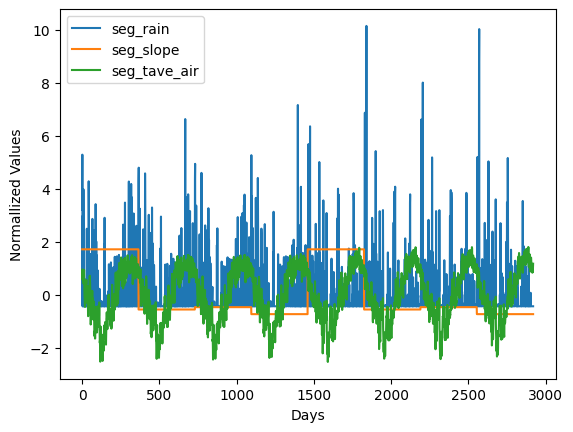

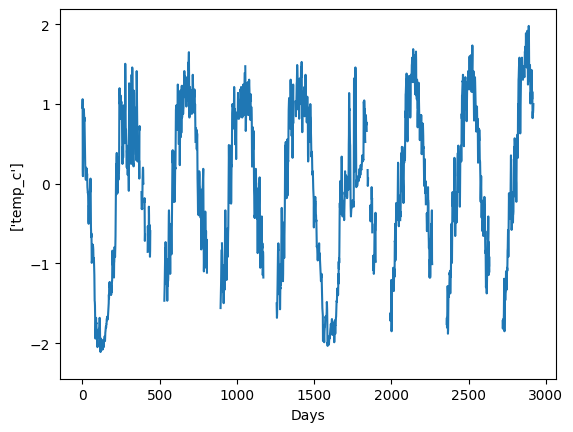

In [7]:
# Create some plots to visualize the data

# Input/Features Data
plt.figure(1)
plt.plot(x_trn[:,:])
plt.legend(x_feats)
plt.xlabel('Days') 
plt.ylabel('Normallized Values') 

# Output Response Variable
plt.figure(2)
plt.plot(y_obs_trn)
plt.xlabel('Days') 
plt.ylabel(y_var) 
plt.xlabel('Days') 

In [8]:
# Create sample weights to use as masks later (1 for real number, 0 for nan)
y_weight_trn = (~np.isnan(y_obs_trn))*1
y_weight_val = (~np.isnan(y_obs_val))*1

# Convert the booleans to numbers
y_weight_trn = y_weight_trn.astype(np.float32)
y_weight_val = y_weight_val.astype(np.float32)

# Replace NaNs in original data with zeros
y_obs_trn = np.nan_to_num(y_obs_trn, nan = 0)
y_obs_val = np.nan_to_num(y_obs_val, nan = 0)

Text(0, 0.5, 'y weights')

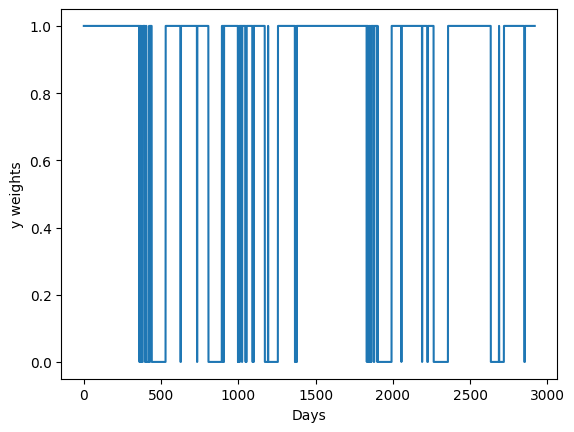

In [9]:
# Weights for the y variables
plt.figure(3)
plt.plot(y_weight_trn)
plt.xlabel('Days') 
plt.ylabel('y weights') 


In [10]:
# concatenate arrays to make a simple array for use in dataset creation
# creates a [numdays, numfeat+2] sized array, where the + 2 is for the y time series and the weights 
arr = np.concatenate((x_trn, y_obs_trn, y_weight_trn), axis = 1)

#Sanity check for shape
print(arr)
np.shape(arr)

[[ 3.2183046   1.72421928  0.95475395  0.95302128  1.        ]
 [ 5.29503917  1.72421928  0.66564279  1.06025913  1.        ]
 [-0.42435482  1.72421928  0.60139587  0.18703667  1.        ]
 ...
 [-0.42435482 -0.72114952  0.85737971  0.89174251  1.        ]
 [-0.42435482 -0.72114952  1.01197387  0.9223819   1.        ]
 [-0.42435482 -0.72114952  1.1816259   0.99898036  1.        ]]


(2920, 5)

In [11]:
# Custom windowing because TF datasets are a bit of a pain to window 
# Goal is to take long time series and create a series of windows of length sequence length
# such that we have a three dimensional array of shape (number of windows, num values in window, num features)

trainX = []
trainY = []
trainYwgt = []

valX = []
valY = []

# Creating windows of length sequence_length
for i in range(sequence_length, len(arr)-1):
    trainX.append(arr[i - sequence_length:i, 0:nfeats]) #arr.shape should be number of features
    trainY.append(arr[i, nfeats])
    trainYwgt.append(arr[i, nfeats+1])

for i in range(sequence_length, len(y_obs_val)-1):
    valX.append(arr[i - sequence_length:i, 0:nfeats]) #arr.shape should be number of features
    valY.append(arr[i, nfeats])
    
trainX, trainY, trainYwgt = np.array(trainX), np.array(trainY), np.array(trainYwgt)
valX, valY = np.array(valX), np.array(valY)

# reshape the y arrays
trainY = np.reshape(trainY,(len(trainY),1))
#trainYwgt = np.reshape(trainYwgt,(len(trainYwgt),1))

# Output shapes for sanity check
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('weightY shape == {}.'.format(trainYwgt.shape))
print()

print('valX shape == {}.'.format(valX.shape))
print('valY shape == {}.'.format(valY.shape))
print('weightY shape == {}.'.format(trainYwgt.shape))

trainX shape == (2905, 14, 3).
trainY shape == (2905, 1).
weightY shape == (2905,).

valX shape == (1445, 14, 3).
valY shape == (1445,).
weightY shape == (2905,).


## 3 TensorFlow Model: Compiling and Fitting

In [12]:
# Create blank weight array to use as template for TF model
y_weights = np.ones((sequence_length,))

# Establish layer shapes for TF model
inputs = tf.keras.layers.Input(shape=(sequence_length, 3))
lstm_out = tf.keras.layers.LSTM(32)(inputs)
outputs = tf.keras.layers.Dense(1)(lstm_out)

# Initialize and Compile Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss=['mse'],
              weighted_metrics = ['mse']
              )

# Display Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 3)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Create callback function so that we can save some important information
path_checkpoint = "model_checkpoint.h5"
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [14]:
# fit the model!!!
history = model.fit(
    x=trainX,
    y=trainY,
    sample_weight = trainYwgt,
    batch_size = batch_size,
    epochs=epochs,
    validation_split = 0.1, 
    callbacks=[es_callback, modelckpt_callback])

Epoch 1/100
36/41 [=========================>....] - ETA: 0s - loss: 0.2906 - mse: 0.3658
Epoch 1: val_loss improved from inf to 0.06104, saving model to model_checkpoint.h5
41/41 [==============================] - 5s 31ms/step - loss: 0.2656 - mse: 0.3360 - val_loss: 0.0610 - val_mse: 0.0875
Epoch 2/100
40/41 [============================>.] - ETA: 0s - loss: 0.0738 - mse: 0.0933
Epoch 2: val_loss improved from 0.06104 to 0.05876, saving model to model_checkpoint.h5
41/41 [==============================] - 1s 13ms/step - loss: 0.0742 - mse: 0.0939 - val_loss: 0.0588 - val_mse: 0.0842
Epoch 3/100
41/41 [==============================] - ETA: 0s - loss: 0.0628 - mse: 0.0795
Epoch 3: val_loss improved from 0.05876 to 0.04894, saving model to model_checkpoint.h5
41/41 [==============================] - 1s 15ms/step - loss: 0.0628 - mse: 0.0795 - val_loss: 0.0489 - val_mse: 0.0702
Epoch 4/100
40/41 [============================>.] - ETA: 0s - loss: 0.0565 - mse: 0.0714
Epoch 4: val_loss di

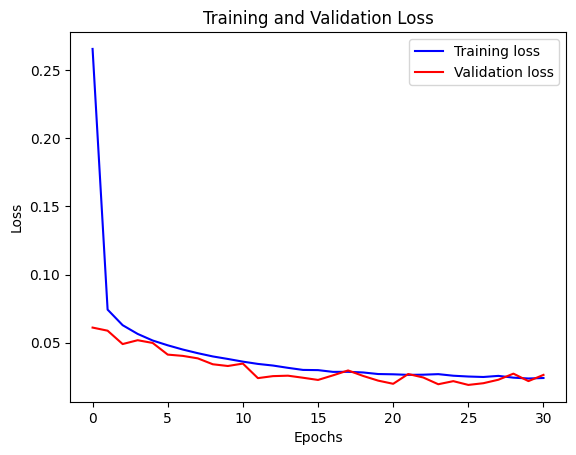

In [15]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

## 4 Use Model to Predict 

In [16]:
# here we'll feed in a new short time series and compare it to the known y values

testValues = model.predict(valX)

46/46 [==============================] - 1s 3ms/step


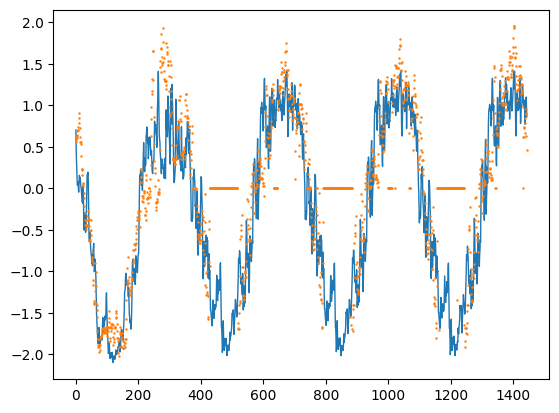

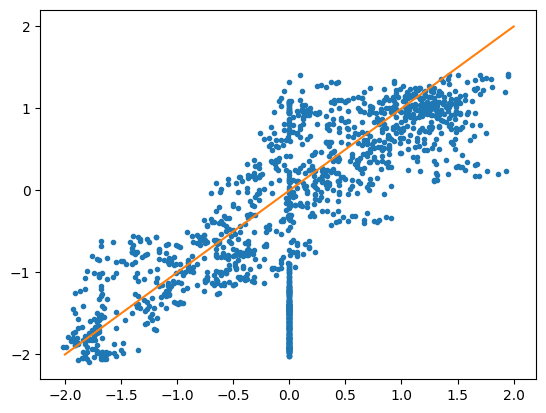

In [17]:
plt.figure(2)
plt.plot(testValues, linewidth = 1)
plt.plot(y_obs_val[15:1460,0], '.', markersize = 1.5)


plt.figure(3)
plt.plot(y_obs_val[15:1460,0],testValues, '.')
plt.plot([-2,2], [-2,2])

In [18]:
# Calculate Model Metrics

# function for NSE
def NSE(ObsData, ModData, ObsWeight):
    
    # calculate mean of the obs (excluding the NA ones)
    Obs_Mean = np.sum(np.multiply(ObsData , ObsWeight))/np.sum(ObsWeight)
    
    # calculate numerator and denominator for the NSE metric
    NSE_NUM = np.sum(np.multiply(np.square(ObsData - ModData),ObsWeight))
    NSE_DEN = np.sum(np.multiply(np.square(ObsData - Obs_Mean),ObsWeight))
    
    NSE_val = 1 - NSE_NUM /NSE_DEN
    
    return NSE_val



# function for PBIAS
def PBIAS(ObsData, ModData, ObsWeight):
    
    PBIAS_NUM = np.sum(np.multiply((ModData - ObsData),ObsWeight))
    PBIAS_DEN = np.sum(np.multiply(ObsData,ObsWeight))
    
    PBIAS_val = PBIAS_NUM / PBIAS_DEN
    
    return(PBIAS_val)

# basic statistics


obsY       = np.reshape(y_obs_val[15:1460,0],(len(y_obs_val[15:1460,0]),1))
obsYweight = np.reshape(y_weight_val[15:1460,0],(len(y_weight_val[15:1460,0]),1))


NSE_TEST   = NSE(obsY , testValues, obsYweight)
PBIAS_TEST = PBIAS(obsY , testValues, obsYweight)*100


print('NSE   == {:.3f}'.format(NSE_TEST))
print('PBIAS == {:.3f}%'.format(PBIAS_TEST))

NSE   == 0.777
PBIAS == -147.632%
